In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast

from transformers import BartTokenizer
from transformers import pipeline

## Data

Note that data preprocessing has been done in [preprocess.ipynb](preprocess.ipynb). The notebook will clean, merge and save the data to `data/processed`.

In [3]:
df = pd.read_csv('../data/processed/preprocessed.csv', index_col=0)
# Transform genres column to list of strings, remove brackets split by comma and remove ' from begining and end
df['genres'] = df['genres'].apply(ast.literal_eval)
print(df.shape)
df.head(5)

(22394, 10)


,name,release_year,rating,num_votes,wikipedia_id,plot,freebase_id,languages,countries,genres
0,Miss Jerry,1894.0,5.3,207,10109752,After finding out that her father is suffering...,/m/02q23xk,['Silent film'],['United States of America'],"[Short Film, Silent film, Indie, Black-and-white]"
1,The Corbett-Fitzsimmons Fight,1897.0,5.3,484,28703057,The film no longer exists in its entirety; how...,/m/0czdh_n,[],[],[Sports]
2,The Story of the Kelly Gang,1906.0,6.0,855,142995,The Story of the Kelly Gangs tone is of sorrow...,/m/0120y4,['English Language'],['Australia'],"[Crime Fiction, Silent film, Biography, Indie,..."
3,Robbery Under Arms,1907.0,4.3,25,32986669,Key scenes of the film included the branding o...,/m/04p7yxx,['Silent film'],['Australia'],"[Silent film, Drama]"
4,"Captain Midnight, the Bush King",1911.0,5.4,18,32987200,Edgar Dalimore is the son of wealthy station o...,/m/0h569x9,['Silent film'],[],[Silent film]


### Genres and current issues

In [4]:
unique_genres = df.genres.explode().unique()
print("Number of genres: {}".format(len(unique_genres)))

Number of genres: 348


#### Too many genres

One issue is that there are too many genres, which makes it hard to train a model. At the same time most of these genres are not very useful. For example we have Black-and-white, Animation, which do not really dive into the plot of the movie. Another issue is the existence of subgenres like Romantic Drama, which is a combination of Romance and Drama, which removes the relation with the original genres.

Text(0.5, 1.0, 'Number of movies by number of genres')

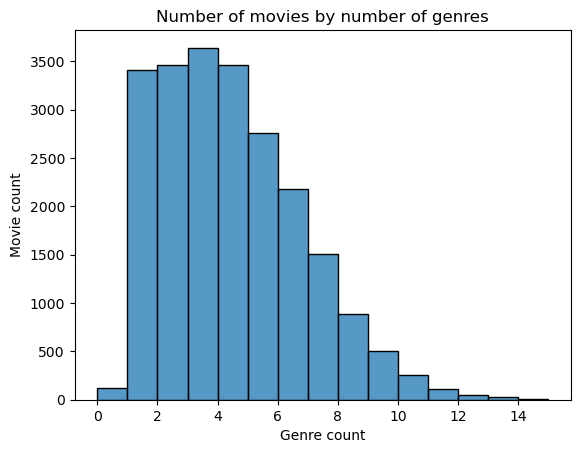

In [5]:
# taken from preprocessing notebook
num_genres = df.genres.apply(lambda x: len(x)).rename('genre_count')
ax = sns.histplot(data=num_genres, bins=np.arange(0, 16, 1))

plt.xlabel('Genre count')
plt.ylabel('Movie count')
plt.title('Number of movies by number of genres')

#### Genre distribution

The distribution looks as something we would expect, most of the movies having assigned only a few genres, while some movies have many genres assigned to them. The goal is to keep this skewness in the data, but to reduce the number of possible genres.

Text(0.5, 1.0, 'Number of movies by genre')

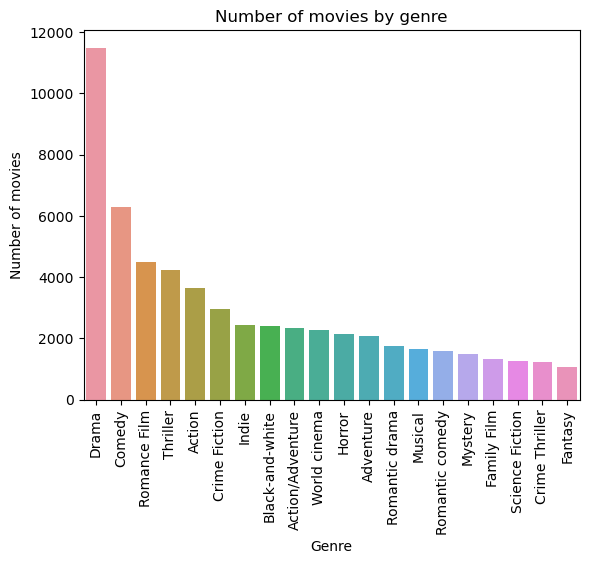

In [6]:
# taken from preprocessing notebook
count_min = 1000
genre_count = df.genres.explode().value_counts()
popular_genres = genre_count[genre_count > count_min]

# plot the count of each genre
sns.barplot(x=popular_genres.index, y=popular_genres.values)

plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of movies')
plt.title('Number of movies by genre')

#### Genre popularity and entanglement

Even among the most popular genres there exists some sort of irrelevant entanglement. While genres like Comedy and Drama are not really entangled as they lead to different emotions during a movie, genres like Science-Fiction or Crime are entangled with genres like Drama and Comedy as they are not really genres, but rather settings or themes.

### Classification settings

#### Genres as labels

First we need to determine which Genres to use. For that we will use the information in the most popular genres as well as the entanglement between genres. The solution focuses on making the difference between genres and themes. While the model is able to give predictions in terms of probabilities that sum up to one, we will use the model on these 2 different dimensions (genres and themes) separately.

We define the following genres (We will refer as a genre to a genre that focuses around a specific emotion or feeling):
* Drama
* Comedy
* Action
* Horror
* Romance
* Thriller
* Adventure
* Documentary

And the following themes (We will refer as a theme to a genre that focuses around a specific setting or scenario):
* Science-Fiction
* Crime
* Fantasy
* War
* Mystery
* History
* Western
* Biographical
* Family

In [7]:
genre_labels = ['Drama', 'Comedy', 'Action', 'Horror', 'Romance', 'Thriller', 'Adventure', 'Documentary']
theme_labels = ['Science-Fiction', 'Crime', 'Fantasy', 'War', 'Mystery', 'History', 'Western', 'Biographical', 'Family']

In [8]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [9]:
# We will take a sample of 100 movies for this analysis
sample = df.sample(100, random_state=42)

#### Classification experiment

In order to make sure our assumption that splitting the genres and themes will improve the performance of the model, we will run a classification experiment. We will use the genres, the themes, and both of them as labels and compare the results.

In [10]:
from tqdm import tqdm

genre_probabilities = {}
theme_probabilities = {}
full_probabilities = {}
hypothesis_template = 'The genre of this movie is {}.'

for i, row in tqdm(sample.iterrows(), total=sample.shape[0]):
    genre_probabilities[row['name']] = classifier(row['plot'], genre_labels, multilabel=True, hypothesis_template=hypothesis_template)
    theme_probabilities[row['name']] = classifier(row['plot'], theme_labels, multilabel=True, hypothesis_template=hypothesis_template)
    full_probabilities[row['name']] = classifier(row['plot'], genre_labels + theme_labels, multilabel=True, hypothesis_template=hypothesis_template)

100%|██████████| 100/100 [1:31:57<00:00, 55.18s/it]


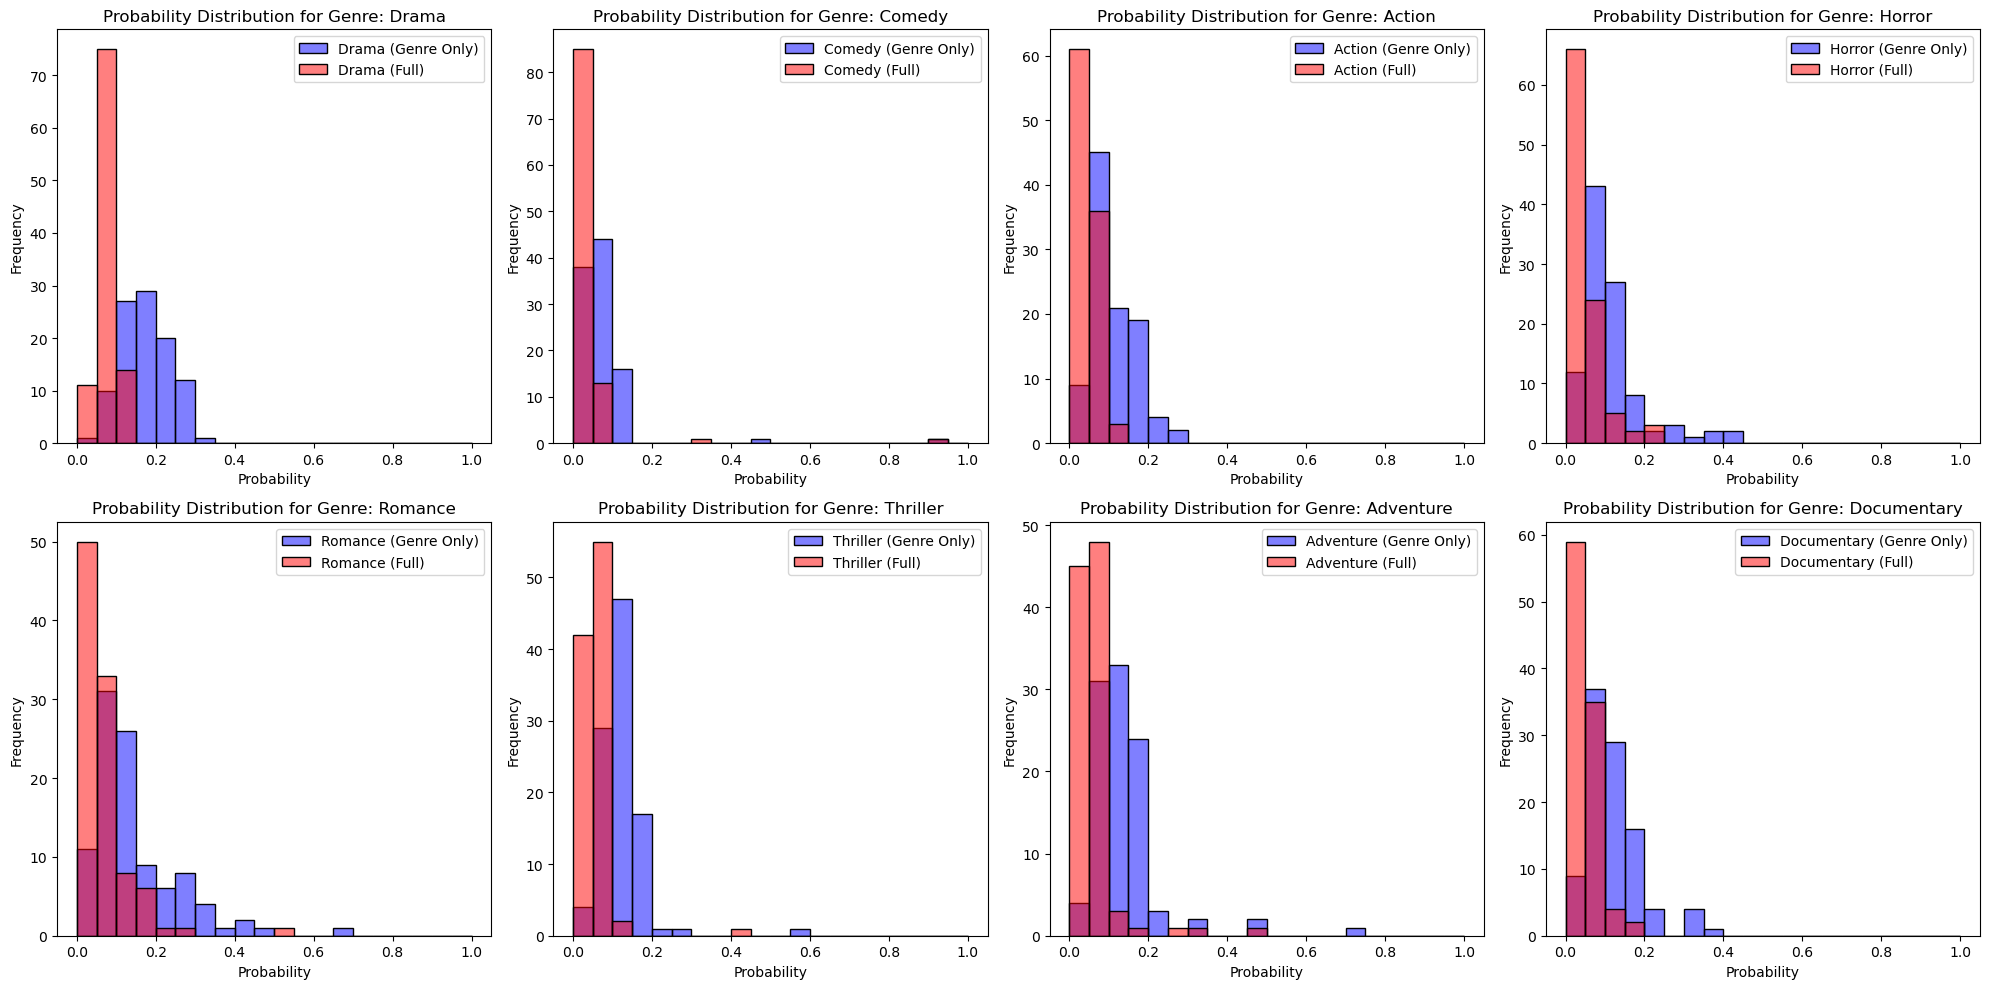

In [34]:
n_rows = 2
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, genre in enumerate(genre_labels):
    genre_probs = [genre_probabilities[movie]['scores'][genre_probabilities[movie]['labels'].index(genre)] for movie in genre_probabilities]
    full_probs = [full_probabilities[movie]['scores'][full_probabilities[movie]['labels'].index(genre)] for movie in full_probabilities]

    sns.histplot(genre_probs, bins=np.arange(0, 1.05, 0.05), ax=axes[i], color='blue', label=f'{genre} (Genre Only)', alpha=0.5)
    sns.histplot(full_probs, bins=np.arange(0, 1.05, 0.05), ax=axes[i], color='red', label=f'{genre} (Full)', alpha=0.5)
    axes[i].set_title(f'Probability Distribution for Genre: {genre}')
    axes[i].set_xlabel('Probability')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.show()

Now let's see how the genres and themes are distributed in the dataset.

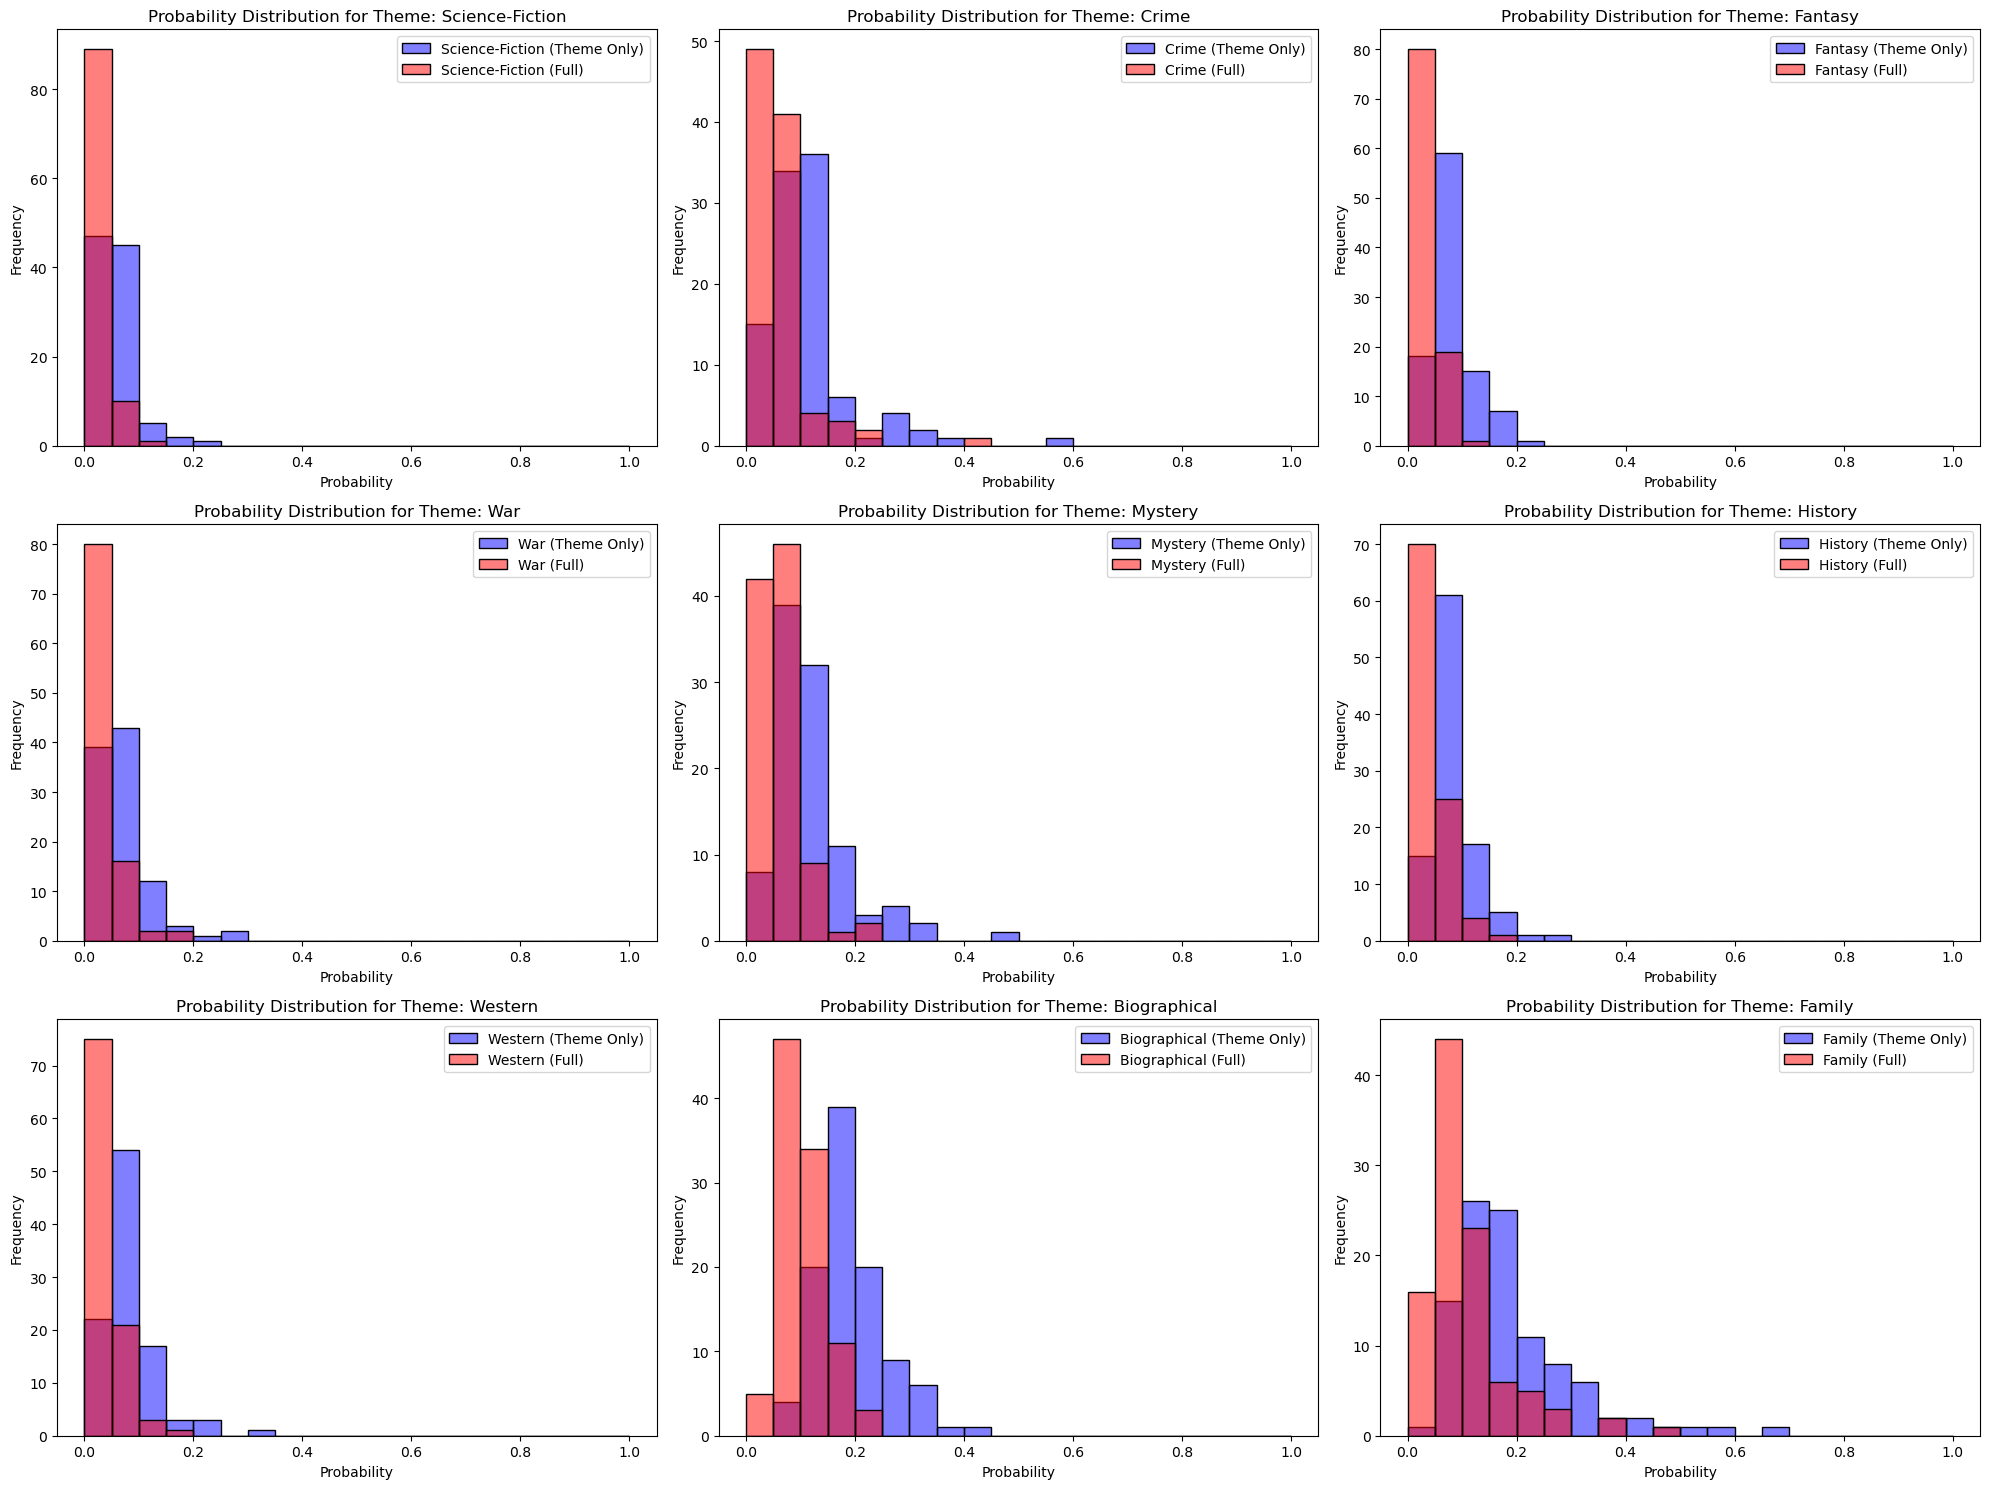

In [33]:
n_rows = 3
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, theme in enumerate(theme_labels):
    theme_probs = [theme_probabilities[movie]['scores'][theme_probabilities[movie]['labels'].index(theme)] for movie in theme_probabilities]
    full_probs = [full_probabilities[movie]['scores'][full_probabilities[movie]['labels'].index(theme)] for movie in full_probabilities]

    sns.histplot(theme_probs, bins=np.arange(0, 1.05, 0.05), ax=axes[i], color='blue', label=f'{theme} (Theme Only)', alpha=0.5)
    sns.histplot(full_probs, bins=np.arange(0, 1.05, 0.05), ax=axes[i], color='red', label=f'{theme} (Full)', alpha=0.5)
    axes[i].set_title(f'Probability Distribution for Theme: {theme}')
    axes[i].set_xlabel('Probability')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.show()

Based on this visualization we can see a tendancy for the themes to have higher probabilities than the genres and we could argue that this might happens as we use the plot to predict the genres and the themes are more related to the plot than the genres. So by splitting the themes and genres we divide the fights in equal weigth groups, so it leads to a more balanced prediction of themes and genres, because otherwise we may have way more themes than genres.

Another point guiding us that splitting them is a good decision is given by the fact that Drama appears much more when splitted than when not splitted, which is a good sign as it is the most common genre in the dataset.

### Genre selection

For computing the graph we need an unweighted graph, so we need to concretize the actual genres that we will use. The graph will basically have an edge betweeen 2 movies if they share either a genra or a theme. We will use the genres and themes that we defined above.

In order to define wheter or not a movie has a genre or a theme we will use the following majority rule:
* We will take the most relevant genres until we reach more than 0.5 summed probability

In [44]:
movie_genres = {}
movie_themes = {}

majority_threshold = 0.5

for movie in genre_probabilities:
    movie_genres[movie] = []
    sum_prob = 0
    for i, genre in enumerate(genre_probabilities[movie]['labels']):
        if sum_prob > majority_threshold:
            break
        movie_genres[movie].append(genre)
        sum_prob += genre_probabilities[movie]['scores'][i]

for movie in theme_probabilities:
    movie_themes[movie] = []
    sum_prob = 0
    for i, theme in enumerate(theme_probabilities[movie]['labels']):
        if sum_prob > majority_threshold:
            break
        movie_themes[movie].append(theme)
        sum_prob += theme_probabilities[movie]['scores'][i]

assert(movie_genres.keys() == movie_themes.keys())

Now let's see again how many genres and themes a movie has after applying the majority rule.

In [45]:
# Create a new dataframe with the movie name, plot, genres, and themes
df_genres_themes = pd.DataFrame(columns=['name', 'plot', 'genres', 'themes'])
df_genres_themes['name'] = movie_genres.keys()
df_genres_themes['plot'] = [sample[sample['name'] == movie]['plot'].values[0] for movie in movie_genres.keys()]
df_genres_themes['genres'] = [movie_genres[movie] for movie in movie_genres.keys()]
df_genres_themes['themes'] = [movie_themes[movie] for movie in movie_themes.keys()]

df_genres_themes.head(5)

,name,plot,genres,themes
0,Janasheen,Lucky Kapoor lives in Australia and has no in...,"[Romance, Drama, Thriller, Horror]","[Family, Biographical, Crime]"
1,American Venus,Jenna is a teen age competitive skater who ha...,[Thriller],"[Family, Biographical, Crime]"
2,Beau Geste,"The plot concerns a valuable gem, which one of...","[Adventure, Drama]","[Crime, Mystery, Family]"
3,Gaayam 2,Ram is a restaurant owner in Bangkok. Ram lea...,"[Drama, Action, Thriller]","[Biographical, Family, Crime]"
4,The Return of a Man Called Horse,Trappers with government support force the Yel...,"[Drama, Adventure, Action]","[Biographical, Western]"


Text(0.5, 1.0, 'Number of movies by number of themes')

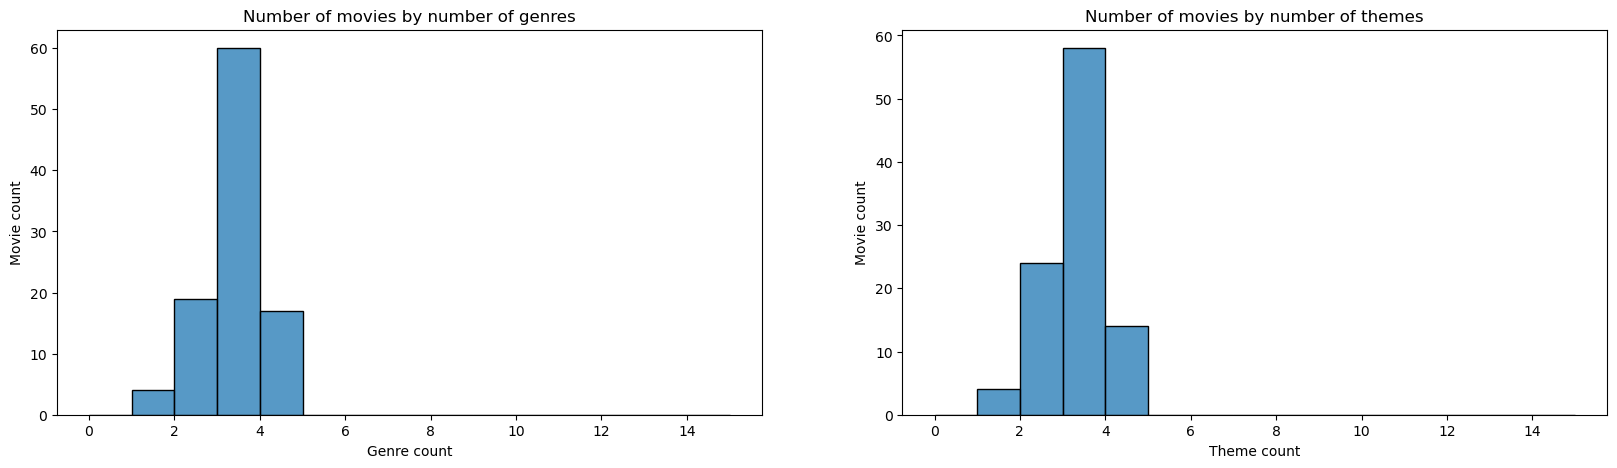

In [46]:
num_genres = df_genres_themes.genres.apply(lambda x: len(x)).rename('genre_count')
num_themes = df_genres_themes.themes.apply(lambda x: len(x)).rename('theme_count')

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.histplot(data=num_genres, bins=np.arange(0, 16, 1), ax=axes[0])

axes[0].set_xlabel('Genre count')
axes[0].set_ylabel('Movie count')
axes[0].set_title('Number of movies by number of genres')

sns.histplot(data=num_themes, bins=np.arange(0, 16, 1), ax=axes[1])

axes[1].set_xlabel('Theme count')
axes[1].set_ylabel('Movie count')
axes[1].set_title('Number of movies by number of themes')

We see a better distribution of genres and themes, which is a good sign as we will have a more balanced graph. This time most of the movies have around 3-4 genres, while only a few have around 5. At the same time this is a sample so it would be possible for the distribution to be different and have a few more outliers even though the number is limited to 8 and 9 respectively.

Now let's look at the distribution by genres and themes.

Text(0.5, 1.0, 'Number of movies by theme')

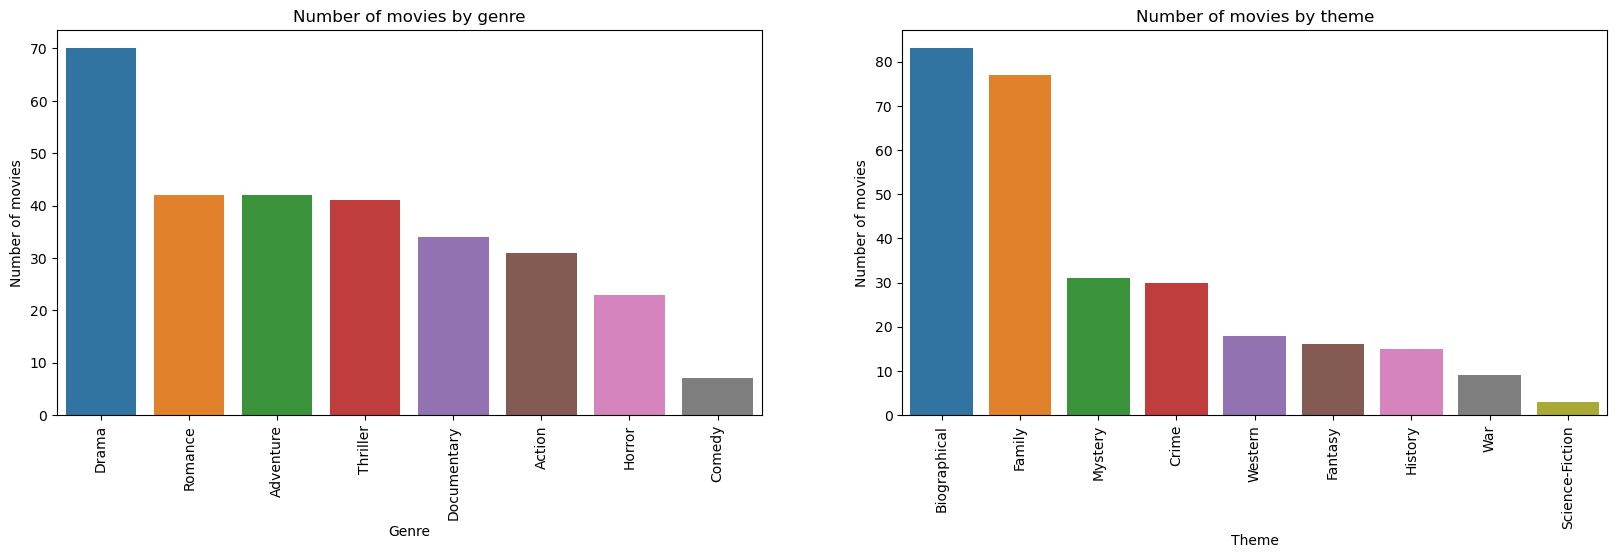

In [47]:
genre_count = df_genres_themes.genres.explode().value_counts()
theme_count = df_genres_themes.themes.explode().value_counts()

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.barplot(x=genre_count.index, y=genre_count.values, ax=axes[0])

axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Number of movies')
axes[0].set_title('Number of movies by genre')

sns.barplot(x=theme_count.index, y=theme_count.values, ax=axes[1])

axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
axes[1].set_xlabel('Theme')
axes[1].set_ylabel('Number of movies')
axes[1].set_title('Number of movies by theme')

The new distribution looks pretty similar and still contains a wide range of genres and themes without all the entanglement that we had before. We also can see that the genres are more balanced than the themes, which might motivate us to continue only with the genres (To discuss).

Note: It's important to mention that the distribution of genres and themes is not the same as the distribution of genres and themes in the dataset as it's just a small sample. However this is worth exploring as we decide how we create the graph that we will analyze later when using the entire dataset.

### Graph

Now that we have the genres and themes that we will use, we can create the graph. We will use the following algorithm to create the graph:
* For each movie we will create a node
* For each movie we will create an edge to all the movies that share at least one genre or theme with it

We will create two graphs, one with the genres and one with the themes. We will use the genres graph to analyze the genres and the themes graph to analyze the themes.

In [48]:
import networkx as nx

In [49]:
genre_graph = nx.Graph()

genre_graph.add_nodes_from(movie_genres.keys())

for i in range(len(movie_genres.keys())):
    for j in range(i + 1, len(movie_genres.keys())):
        movie1 = list(movie_genres.keys())[i]
        movie2 = list(movie_genres.keys())[j]
        if len(set(movie_genres[movie1]).intersection(set(movie_genres[movie2]))) > 0:
            genre_graph.add_edge(movie1, movie2)

Text(0.5, 1.0, 'Theme Graph')

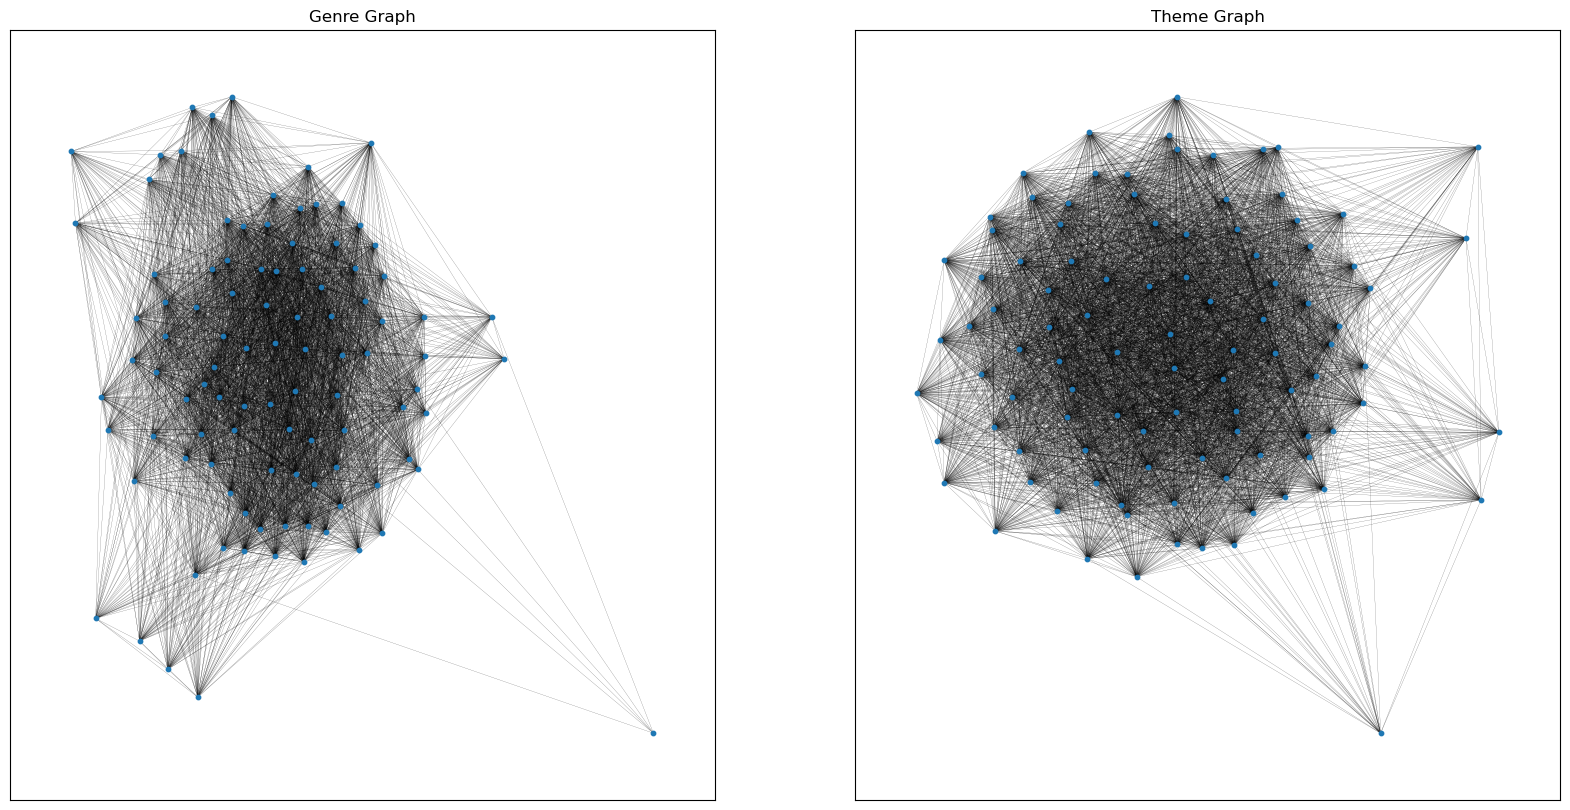

In [53]:
theme_graph = nx.Graph()

theme_graph.add_nodes_from(movie_themes.keys())

for i in range(len(movie_themes.keys())):
    for j in range(i + 1, len(movie_themes.keys())):
        movie1 = list(movie_themes.keys())[i]
        movie2 = list(movie_themes.keys())[j]
        if len(set(movie_themes[movie1]).intersection(set(movie_themes[movie2]))) > 0:
            theme_graph.add_edge(movie1, movie2)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

nx.draw_networkx(genre_graph, ax=axes[0], node_size=10, width=0.1, with_labels=False)
nx.draw_networkx(theme_graph, ax=axes[1], node_size=10, width=0.1, with_labels=False)

axes[0].set_title('Genre Graph')
axes[1].set_title('Theme Graph')